In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model
import gym

In [2]:

from tqdm import tqdm
import os
import time 

In [3]:
epsilon = 1  
EPSILON_DECAY = 0.998 
MIN_EPSILON = 0.01

In [4]:
env = gym.make('LunarLander-v2')

In [5]:
class ActionValueNetwork:
    def __init__(self, network_config):
        self.state_dim = network_config.get("state_dim")
        self.num_hidden_units = network_config.get("num_hidden_units")
        self.num_actions = network_config.get("num_actions")
        self.step_size=network_config.get('step_size')
    def create_model(self):
        i = Input(shape=self.state_dim)
        x = Dense(256, activation='relu')(i)
        x = Dense(128, activation='relu')(x)
        x = Dense(self.num_actions, activation='linear')(x)
        model = Model(i, x)
        model.compile(optimizer=Adam(lr=self.step_size),loss='mse')
        return model

In [6]:
class ReplayBuffer:
    def __init__(self, size, minibatch_size, seed):
       
        self.buffer = []
        self.minibatch_size = minibatch_size
        self.rand_generator = np.random.RandomState(seed)
        self.max_size = size

    def append(self, state, action, reward, terminal, next_state):
     
        if len(self.buffer) == self.max_size:
            del self.buffer[0]
        self.buffer.append([state, action, reward, terminal, next_state])

    def sample(self):
       
        idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]

    def size(self):
        return len(self.buffer)

In [7]:

class Agent:
    def __init__(self, agent_config):
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'], 
                                          agent_config['minibatch_sz'], agent_config.get("seed"))
        self.network = ActionValueNetwork(agent_config['network_config'])
        
        self.model=self.network.create_model()
        
        self.target_model=self.network.create_model()
        
        self.num_actions = agent_config['network_config']['num_actions']
        
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        
        self.rand_generator = np.random.RandomState(agent_config.get("seed"))
        
        self.last_state = None
        self.last_action = None
        self.epsilon = epsilon
        self.sum_rewards = 0
        self.episode_steps = 0

    
    def policy(self, state):
        action_values =self.model.predict(state)
        if (np.random.uniform() < self.epsilon) or (action_values.all() == 0):
            action = np.random.randint(0, env.action_space.n)
        else:
            action=np.argmax(action_values)
        return action

    
    def agent_start(self):
       
        
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = env.reset()
        self.last_state = np.reshape(self.last_state,(-1,self.last_state.shape[0]))
        self.last_action = self.policy(self.last_state)
        return self.last_action


    def agent_step(self, state,reward,terminal):
      
        
        self.sum_rewards += reward
        self.episode_steps += 1
        
        state = np.array([state])
        
     
        action = self.policy(state)
       
        
    

       
        self.replay_buffer.append(self.last_state, self.last_action, reward, terminal, state)
        
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            self.target_model.set_weights(self.model.get_weights())
            for _ in range(self.num_replay):
                experiences = self.replay_buffer.sample()
                self.agent_train(experiences)
        
   
        self.last_state = state
        self.last_action = action
        
        
        return action

    def agent_train(self,experiences):
        states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
        states = np.concatenate(states)
        next_states = np.concatenate(next_states)
        rewards = np.array(rewards)
        terminals = np.array(terminals)
        batch_size1 = states.shape[0]
        q_next_mat = self.target_model.predict(next_states)
        
        v_next_vec = np.max(q_next_mat, axis=1)*(1-terminals)
        
        target_vec = rewards + self.discount*v_next_vec
       
        q_mat = self.model.predict(states)
      
        batch_indices = np.arange(q_mat.shape[0])

        X=states
        q_mat[batch_indices,actions] = target_vec
 
        self.model.fit(X,q_mat,batch_size=batch_size1,verbose=0,shuffle=False)
        
    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")
    

In [13]:
agent_info = {
             'network_config': {
                 'state_dim': 8,
                 'num_actions': 4,
                 'step_size':1e-3
             },
             'replay_buffer_size': 50000,
             'minibatch_sz': 64,
             'num_replay_updates_per_step': 4,
             'gamma': 0.99,
             'seed': 0}
EPISODES = 500

In [14]:
agent=Agent(agent_info)

In [15]:
reward_episode=[]
no_episodes=[]
episode_steps=[]
eps_history=[]

In [115]:
for episode in range(404,601):
    action=agent.agent_start()
    terminal=0
    while terminal!=1:
        state,reward,terminal,info=env.step(action)
        if terminal==True:
            terminal=1
        else:
            terminal=0
        action=agent.agent_step(state,reward,terminal)
        if agent.epsilon > MIN_EPSILON:
            agent.epsilon *= EPSILON_DECAY
            agent.epsilon = max(MIN_EPSILON,agent.epsilon)
    reward = agent.agent_message('get_sum_reward')
    reward_episode.append(reward)
    no_episodes.append(episode)
    episode_steps.append(agent.episode_steps)
    eps_history.append(agent.epsilon)
    print('episode: ', episode,'score: ',reward,
            'epsilon %.2f' % agent.epsilon, 'steps', agent.episode_steps)

episode:  404 score:  92.23341207362776 epsilon 0.01 steps 1000
episode:  405 score:  214.89169155036916 epsilon 0.01 steps 659
episode:  406 score:  277.035108899467 epsilon 0.01 steps 478
episode:  407 score:  258.54086560011666 epsilon 0.01 steps 434
episode:  408 score:  246.8568405866114 epsilon 0.01 steps 295
episode:  409 score:  241.46439329836087 epsilon 0.01 steps 347
episode:  410 score:  108.19756161925571 epsilon 0.01 steps 1000
episode:  411 score:  206.99447922792388 epsilon 0.01 steps 699
episode:  412 score:  -44.782192350794446 epsilon 0.01 steps 484
episode:  413 score:  57.7818360272321 epsilon 0.01 steps 1000
episode:  414 score:  246.43799802364646 epsilon 0.01 steps 472
episode:  415 score:  251.8617823422895 epsilon 0.01 steps 663
episode:  416 score:  -333.97920541155065 epsilon 0.01 steps 409
episode:  417 score:  165.35499399574994 epsilon 0.01 steps 1000
episode:  418 score:  223.3347124087345 epsilon 0.01 steps 234
episode:  419 score:  234.4214427012577 ep

episode:  533 score:  282.7538023757835 epsilon 0.01 steps 210
episode:  534 score:  157.31545448127918 epsilon 0.01 steps 1000
episode:  535 score:  -88.52218575068805 epsilon 0.01 steps 186
episode:  536 score:  264.99912197887284 epsilon 0.01 steps 285
episode:  537 score:  25.40269930959741 epsilon 0.01 steps 192
episode:  538 score:  231.66620610305685 epsilon 0.01 steps 303
episode:  539 score:  286.16343889214625 epsilon 0.01 steps 245
episode:  540 score:  260.6418432980457 epsilon 0.01 steps 431
episode:  541 score:  261.3829126112992 epsilon 0.01 steps 238
episode:  542 score:  216.5408090738575 epsilon 0.01 steps 570
episode:  543 score:  276.26467510214775 epsilon 0.01 steps 254
episode:  544 score:  265.7028233468925 epsilon 0.01 steps 209
episode:  545 score:  270.7450276655028 epsilon 0.01 steps 288
episode:  546 score:  294.8146472732823 epsilon 0.01 steps 275
episode:  547 score:  167.25861163881297 epsilon 0.01 steps 699
episode:  548 score:  281.11976164988334 epsilo

In [285]:
for episode in range(0,300):
    action=agent1.agent_start()
    terminal=0
    while terminal!=1:
        state,reward,terminal,info=env.step(action)
        if terminal==True:
            terminal=1
        else:
            terminal=0
        action=agent1.agent_step(state,reward,terminal)
    reward = agent1.agent_message('get_sum_reward')
    reward_episode.append(reward)
    no_episodes.append(episode)
    episode_steps.append(agent1.episode_steps)
    print('episode: ', episode,'score: ',reward,
            'epsilon %.2f' % agent1.epsilon, 'steps', agent1.episode_steps)

episode:  0 score:  272.35157979382643 epsilon 0.01 steps 316
episode:  1 score:  237.51253971293463 epsilon 0.01 steps 260
episode:  2 score:  265.1535574777305 epsilon 0.01 steps 315
episode:  3 score:  252.93729150742732 epsilon 0.01 steps 253
episode:  4 score:  258.5828958872403 epsilon 0.01 steps 278
episode:  5 score:  289.5859128803414 epsilon 0.01 steps 250
episode:  6 score:  261.99215392417966 epsilon 0.01 steps 228
episode:  7 score:  233.0605012918775 epsilon 0.01 steps 287
episode:  8 score:  251.38290256103238 epsilon 0.01 steps 300
episode:  9 score:  282.35205589332486 epsilon 0.01 steps 267
episode:  10 score:  279.7620874077648 epsilon 0.01 steps 315
episode:  11 score:  273.37387745424013 epsilon 0.01 steps 211
episode:  12 score:  262.34429978181475 epsilon 0.01 steps 281
episode:  13 score:  238.3350485854804 epsilon 0.01 steps 249
episode:  14 score:  232.33454210946218 epsilon 0.01 steps 222
episode:  15 score:  258.8886709499161 epsilon 0.01 steps 261
episode: 

episode:  131 score:  251.78907197264166 epsilon 0.01 steps 250
episode:  132 score:  268.29100680863223 epsilon 0.01 steps 355
episode:  133 score:  267.6597238689768 epsilon 0.01 steps 280
episode:  134 score:  255.03654750302624 epsilon 0.01 steps 256
episode:  135 score:  251.14539178306376 epsilon 0.01 steps 333
episode:  136 score:  257.31324636517644 epsilon 0.01 steps 221
episode:  137 score:  274.9505013247996 epsilon 0.01 steps 270
episode:  138 score:  294.87371914692164 epsilon 0.01 steps 323
episode:  139 score:  255.44787912982122 epsilon 0.01 steps 210
episode:  140 score:  246.8220328677592 epsilon 0.01 steps 236
episode:  141 score:  282.0420448272476 epsilon 0.01 steps 374
episode:  142 score:  255.5285709015813 epsilon 0.01 steps 212
episode:  143 score:  229.13065452104536 epsilon 0.01 steps 281
episode:  144 score:  245.06862740431114 epsilon 0.01 steps 233
episode:  145 score:  235.13428522708807 epsilon 0.01 steps 262
episode:  146 score:  216.76746082067785 epsi

episode:  260 score:  283.37303543168434 epsilon 0.01 steps 318
episode:  261 score:  272.77266722869985 epsilon 0.01 steps 227
episode:  262 score:  294.4509463583148 epsilon 0.01 steps 272
episode:  263 score:  269.6317028857906 epsilon 0.01 steps 289
episode:  264 score:  252.42089812503696 epsilon 0.01 steps 282
episode:  265 score:  256.4295021751452 epsilon 0.01 steps 225
episode:  266 score:  284.8367828923824 epsilon 0.01 steps 299
episode:  267 score:  248.15337464060468 epsilon 0.01 steps 216
episode:  268 score:  252.2725074687844 epsilon 0.01 steps 275
episode:  269 score:  215.511895732526 epsilon 0.01 steps 289
episode:  270 score:  288.22589996273325 epsilon 0.01 steps 260
episode:  271 score:  249.02209359706637 epsilon 0.01 steps 403
episode:  272 score:  286.22124900658673 epsilon 0.01 steps 260
episode:  273 score:  266.54676154544484 epsilon 0.01 steps 235
episode:  274 score:  272.7969369174241 epsilon 0.01 steps 298
episode:  275 score:  263.4463461502056 epsilon 

In [324]:
reward_episode1=reward_episode[601:]

In [325]:
for i in range(0,300):
    no_episodes1.append(i)

In [326]:
reward_episode1[296]=200

In [327]:
len(no_episodes1)

300

In [328]:
episode_steps1=episode_steps[601:]

In [329]:
len(episode_steps1)

300

In [330]:
for i in no_episodes1:
    k=np.mean(reward_episode1[i:i+100])
    k=np.round(k,3)
    new_avgone.append(k)

In [344]:
len(new_avgone)

300

In [346]:
new_avgone

[262.083,
 261.905,
 262.061,
 261.712,
 261.775,
 261.563,
 261.257,
 261.207,
 261.635,
 261.92,
 261.637,
 261.359,
 261.444,
 261.293,
 261.73,
 262.04,
 262.073,
 261.767,
 262.109,
 262.528,
 262.34,
 261.156,
 261.301,
 261.168,
 261.108,
 260.387,
 259.081,
 258.974,
 258.404,
 258.486,
 258.493,
 258.36,
 258.098,
 258.434,
 258.334,
 258.167,
 258.292,
 258.421,
 258.28,
 258.507,
 258.517,
 258.358,
 258.402,
 258.535,
 258.039,
 257.788,
 258.527,
 258.343,
 258.391,
 258.383,
 258.382,
 258.66,
 258.688,
 257.414,
 257.437,
 257.868,
 257.832,
 257.77,
 257.805,
 257.327,
 256.927,
 256.891,
 256.599,
 255.135,
 254.976,
 255.46,
 255.399,
 255.46,
 254.941,
 254.726,
 254.335,
 254.66,
 254.846,
 254.284,
 254.461,
 254.628,
 254.781,
 254.797,
 254.755,
 255.015,
 254.626,
 254.358,
 253.986,
 254.504,
 254.534,
 254.351,
 254.473,
 254.328,
 254.682,
 254.627,
 254.582,
 254.758,
 254.428,
 256.04,
 255.901,
 255.405,
 255.394,
 255.083,
 254.796,
 254.806,
 254.751,
 2

In [347]:
reward_episode1

[272.35157979382643,
 237.51253971293463,
 265.1535574777305,
 252.93729150742732,
 258.5828958872403,
 289.5859128803414,
 261.99215392417966,
 233.0605012918775,
 251.38290256103238,
 282.35205589332486,
 279.7620874077648,
 273.37387745424013,
 262.34429978181475,
 238.3350485854804,
 232.33454210946218,
 258.8886709499161,
 284.1522792688361,
 233.61379202156695,
 250.65069139996274,
 253.57436823183536,
 280.9684069392782,
 256.8104159932566,
 263.31222609421434,
 242.9972629687484,
 243.93173613039252,
 267.7047673878504,
 272.14102549495055,
 297.0222036906114,
 251.846515068486,
 269.2664403186807,
 270.0020883344915,
 277.99121702438913,
 234.65388253218205,
 277.6575401643284,
 271.75059502667216,
 238.63185326064072,
 244.48490776825759,
 288.9678125708629,
 272.1969319897785,
 254.49366438660795,
 262.67819920499767,
 277.610089367365,
 242.31476322901776,
 278.73677348939134,
 270.13203142591067,
 161.2132182695193,
 235.19598167461422,
 256.12376787604387,
 274.3896433038

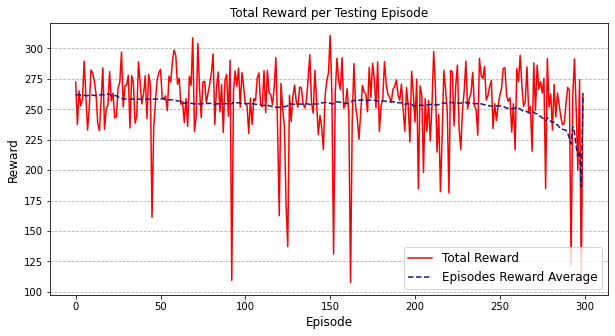

In [343]:
plt.figure(figsize=(10,5))
plt.plot(no_episodes1,reward_episode1, color = 'red',  linestyle = '-', 
        label = 'Total Reward')
plt.plot(no_episodes1, new_avgone, color = 'midnightblue',  linestyle = '--', 
        label = 'Episodes Reward Average')
plt.grid(b = True, which = 'major', axis = 'y', linestyle = '--')
plt.xlabel('Episode', fontsize = 12)
plt.ylabel('Reward',  fontsize = 12)
plt.title('Total Reward per Testing Episode',  fontsize = 12)  
plt.legend(loc = 'lower right', fontsize = 12)    
plt.show()

In [334]:
average_reward=np.mean(new_reward)

In [335]:
average_reward

141.12905657237937

In [336]:
average_reward1=np.mean(reward_episode1)

In [337]:
average_reward1

256.547764407026